In [4]:

import sys
import os
import scanpy as sc
project_path = "/home/lixiangyu/multi-omics/MOMG"
sys.path.append(project_path)

from package import DMG, clustering

In [5]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  # 添加这行导入语句
#image
data = pd.read_csv('/home/lixiangyu/DMG/DMG-main/input/human_breast_cancer/human_breast_cancer_image_resnet_v2_cos_unnormalize.csv',index_col=0)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.values)
pca = PCA(n_components=50)
pca50_image = pca.fit_transform(data_scaled)

num_gpus = 4
# RNA
adata_omics1=sc.read('/home/lixiangyu/multi-omics/SpatialGLUE/rawdata/human_breast_cancer/human_breast_cancer_rna.h5ad')
# sc.pp.filter_genes(adata_omics1, min_cells=10)
# sc.pp.normalize_total(adata_omics1, target_sum=1e4)
# sc.pp.log1p(adata_omics1)
# sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
adata = adata_omics1[:, adata_omics1.var.highly_variable]
sc.tl.pca(adata, n_comps=50)
pca50_rna = adata.obsm['X_pca']

# Protein
import scanpy as sc

# 读取数据
adata_omics1 = sc.read('/home/lixiangyu/multi-omics/SpatialGLUE/rawdata/human_breast_cancer/human_breast_cancer_protein.h5ad')
if adata_omics1.n_vars < 50:
    pca50_atac = adata_omics1.X
else:
    sc.tl.pca(adata_omics1, n_comps=50)
    pca50_atac = adata_omics1.obsm['X_pca']
    

/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


以下基因在数据中缺失: ['LINC00926', 'TXNIP', 'TMSB4X', 'NCF1', 'EVL', 'RNASET2', 'AC103591.3', 'HLA-DQB1', 'TRAF5', 'OGA', 'HLA-DQA1']
找到 39/50 个有效TLS标记基因
TLS区域统计: TLS_tag
No     4018
Yes     151
Name: count, dtype: int64


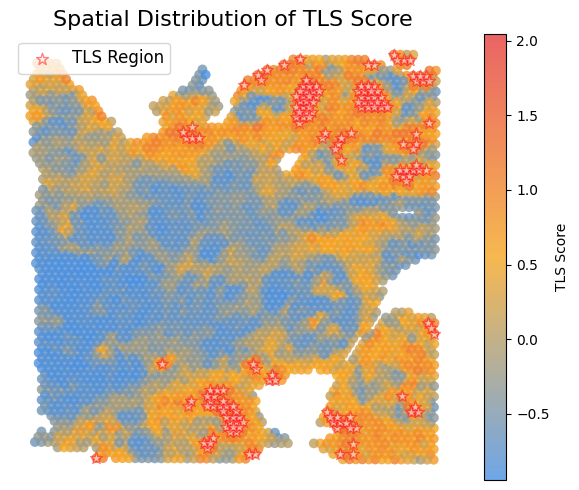

TLS分析完成，结果已保存


In [6]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns

# TLS相关标记基因列表
markers = [
    "FDCSP", "CR2", "CXCL13", "LTF", "CD52", "MS4A1", "CCL19", "LINC00926", "LTB", "CORO1A",
    "CD79B", "TXNIP", "CD19", "LIMD2", "CD37", "ARHGAP45", "BLK", "TMC8", "CCL21", "PTPN6",
    "ATP2A3", "IGHM", "SPIB", "TMSB4X", "CXCR4", "NCF1", "CD79A", "ARHGAP9", "DEF6", "EVL",
    "TBC1D10C", "RASAL3", "INPP5D", "RNASET2", "RASGRP2", "TNFRSF13C", "RAC2", "CD22", "ARHGEF1", "AC103591.3",
    "TRAF3IP3", "HLA-DQB1", "CD53", "ARHGAP4", "TRBC2", "POU2AF1", "TRAF5", "OGA", "FCRL3", "HLA-DQA1"
]
# 首先检查数据中存在的基因
available_genes = adata.var_names.tolist()

# 筛选标记基因中存在于数据中的基因
valid_markers = [gene for gene in markers if gene in available_genes]

# 打印缺失的基因
missing_genes = [gene for gene in markers if gene not in available_genes]
print(f"以下基因在数据中缺失: {missing_genes}")

# 检查有效基因数量
if len(valid_markers) == 0:
    raise ValueError("数据中没有找到任何TLS标记基因，请检查数据或标记基因列表")
else:
    print(f"找到 {len(valid_markers)}/{len(markers)} 个有效TLS标记基因")

temp = adata.X

# 转换为DataFrame并筛选标记基因
temp_df = pd.DataFrame(temp, index=adata.obs_names, columns=adata.var_names)
temp_df = temp_df[valid_markers]

# 处理缺失值
temp_df = temp_df.fillna(0)

# 2. 计算TLS得分
# 计算每个spot的平均表达值作为TLS得分
adata.obs['TLS_score'] = temp_df.mean(axis=1)

# 3. 确定TLS区域
max_score = adata.obs['TLS_score'].max()
# 使用0.6倍最大值作为阈值，可根据需要调整
adata.obs['TLS_tag'] = np.where(
    adata.obs['TLS_score'] >= 0.6 * max_score, 
    'Yes', 
    'No'
)

# 统计TLS区域数量
tls_counts = adata.obs['TLS_tag'].value_counts()
print(f"TLS区域统计: {tls_counts}")

# 4. 空间坐标获取与检查
# 检查是否存在空间坐标，通常存储在adata.obsm['spatial']
if 'spatial' in adata.obsm:
    spatial_coords = adata.obsm['spatial']
    adata.obs['x'] = spatial_coords[:, 1]
    adata.obs['y'] = spatial_coords[:, 0]
else:
    raise ValueError("AnnData对象中未找到空间坐标，请确认数据是否包含空间信息")

# 5. 可视化TLS得分
plt.figure(figsize=(6, 5))

# 创建自定义颜色映射，从蓝色到红色
cmap = LinearSegmentedColormap.from_list('blue_to_red', ['#4A90E2', '#F5A623', '#E53E3E'])

# 绘制TLS得分空间分布
scatter = plt.scatter(
    adata.obs['x'], 
    adata.obs['y'], 
    c=adata.obs['TLS_score'], 
    cmap=cmap,
    s=50,
    alpha=0.8,
    edgecolor='none'
)

# 添加颜色条
cbar = plt.colorbar(scatter, label='TLS Score')
cbar.ax.tick_params(labelsize=10)

# 标记TLS区域(Yes)
tls_spots = adata.obs[adata.obs['TLS_tag'] == 'Yes']
plt.scatter(
    tls_spots['x'], 
    tls_spots['y'], 
    c='white', 
    edgecolor='red', 
    s=80, 
    alpha=0.5,
    marker='*',
    label='TLS Region'
)

# 设置图形属性
plt.title('Spatial Distribution of TLS Score', fontsize=16)
plt.xlabel('X Coordinate', fontsize=12)
plt.ylabel('Y Coordinate', fontsize=12)
plt.axis('off')
plt.legend(fontsize=12)
plt.tight_layout()

# 保存结果
plt.savefig('/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/TLS_score_spatial_distribution_new.png', dpi=300, bbox_inches='tight')
plt.show()


print("TLS分析完成，结果已保存")

In [5]:

import anndata
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.robjects.conversion import localconverter
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
sc.settings.seed = 0
# 加载数据
file_fold = '/home/lixiangyu/DMG/DMG-main/input/human_breast_cancer/'
adata_omics1 = sc.read_h5ad(file_fold + 'human_breast_cancer_rna.h5ad')
print(adata_omics1)
mclust = importr("mclust")
from sklearn.decomposition import PCA

pca = PCA(n_components=40)
X_pca = pca.fit_transform(adata_omics1.X)  

# Store in obsm
adata_omics1.obsm['X_pca'] = X_pca

# 假设 X_pca 是降维后的数据（例如PCA坐标）
X_pca = adata_omics1.obsm["X_pca"][:, :40]  # 使用前20个主成分

# 转换为R矩阵
with localconverter(ro.default_converter + numpy2ri.converter):
    r_X_pca = ro.r.matrix(X_pca, nrow=X_pca.shape[0], ncol=X_pca.shape[1])

# 指定聚类数（例如强制分8类）
mclust_result = mclust.Mclust(r_X_pca, G=10)

clusters = np.array(mclust_result.rx2("classification"))
adata_omics1.obs["mclust_clusters"] = clusters.astype(int)
adata_omics1.obs["mclust_clusters"] = adata_omics1.obs["mclust_clusters"].astype('category')

AnnData object with n_obs × n_vars = 4169 × 15687
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p'
    obsm: 'spatial'


/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


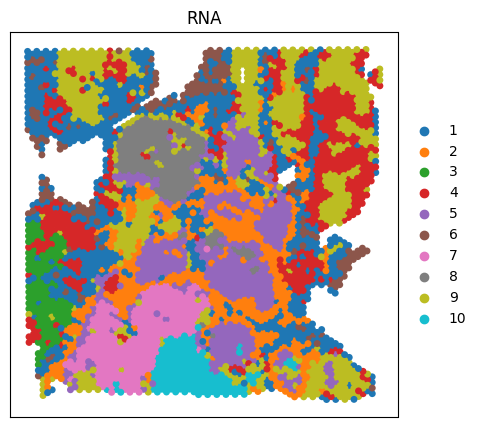

In [7]:
import matplotlib.pyplot as plt
output_path = '/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/RNA.png'
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.embedding(adata_omics1, basis='spatial', color='mclust_clusters', ax=ax, title='RNA', s=100, show=False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.savefig(output_path, format='png')  
plt.show()

In [2]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(0)
sc.settings.seed = 0
# 加载数据
file_fold = '/home/lixiangyu/DMG/DMG-main/input/human_breast_cancer/'
adata_omics2 = sc.read_h5ad(file_fold + 'human_breast_cancer_protein.h5ad')
print(adata_omics2)
import anndata
import numpy as np
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import numpy2ri
from rpy2.robjects.conversion import localconverter

mclust = importr("mclust") 
with localconverter(ro.default_converter + numpy2ri.converter):
  r_X_pca = ro.r.matrix(adata_omics2.X, nrow=adata_omics2.X.shape[0], ncol=adata_omics2.X.shape[1])

mclust_result = mclust.Mclust(r_X_pca, G=10)
clusters = np.array(mclust_result.rx2("classification"))
adata_omics2.obs["mclust_clusters"] = clusters.astype(int)
adata_omics2.obs["mclust_clusters"] = adata_omics2.obs["mclust_clusters"].astype('category')


AnnData object with n_obs × n_vars = 4169 × 35


In [21]:
adata.obs['ADT']=adata_omics2.obs["mclust_clusters"]

In [13]:
import re

# 仅替换最后一个点（例如 "A.C.1" → "A.C-1"）
adata_omics2.obs_names = [re.sub(r"\.(?=[^.]*$)", "-", name) for name in adata_omics2.obs_names]

In [24]:
print(adata.obs['ADT'])

AACACTTGGCAAGGAA-1     7
AACAGGATTCATAGTT-1     4
AACAGGCCAACGATTA-1     1
AACAGGTTATTGCACC-1     2
AACAGGTTCACCGAAG-1     4
                      ..
TGTTGGAACGAGGTCA-1     5
TGTTGGAAGCTCGGTA-1     1
TGTTGGATGGACTTCT-1     1
TGTTGGCCAGACCTAC-1     4
TGTTGGCCTACACGTG-1    10
Name: ADT, Length: 4169, dtype: category
Categories (10, int64): [1, 2, 3, 4, ..., 7, 8, 9, 10]


In [12]:
adata_omics2.obsm['spatial']=adata_omics1.obsm['spatial']

/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


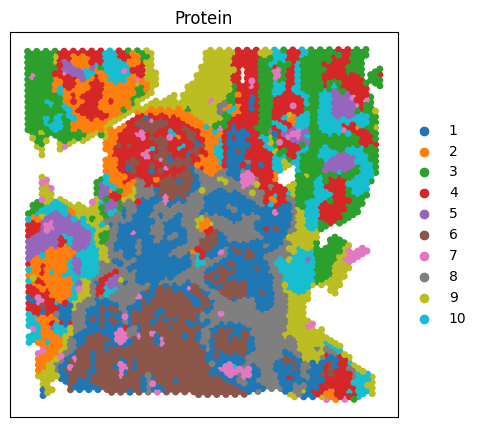

In [13]:
import matplotlib.pyplot as plt
output_path = '/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/Protein.png'
fig, ax = plt.subplots(figsize=(5, 5))
sc.pl.embedding(adata_omics2, basis='spatial', color='mclust_clusters', ax=ax, title='Protein', s=100, show=False)
ax.get_yaxis().set_visible(False)
ax.get_xaxis().set_visible(False)
plt.savefig(output_path, format='png')  
plt.show()

In [1]:
import scanpy as sc
adata_file='/home/lixiangyu/multi-omics/SpatialGLUE/rawdata/human_breast_cancer/human_breast_cancer_7_13.h5ad'
adata=sc.read(adata_file)
print(adata)

/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 4169 × 15687
    obs: 'mclust', 'SpatialGlue_7', 'SpatialGlue_8', 'SpatialGlue_9', 'SpatialGlue_10', 'SpatialGlue_11', 'SpatialGlue_12', 'SpatialGlue_13', 'SpatialGlue_14', 'SpatialGlue_15', 'MISO_rp_7', 'MISO_rp_8', 'MISO_rp_9', 'MISO_rp_10', 'MISO_rp_11', 'MISO_rp_12', 'MISO_rp_13', 'no_image', 'resnet', 'RNA', 'ATAC', 'ADT', 'cluster4_vs_rest', 'MISO_7', 'MISO_8', 'MISO_9', 'MISO_10', 'MISO_11', 'MISO_12', 'MISO_13'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'ADT_cluster_colors', 'ADT_colors', 'MISO_10_colors', 'MISO_rp_10_colors', 'RNA_cluster_colors', 'RNA_colors', 'SpatialGlue_10_colors', 'SpatialGlue_colors', 'adj_spatial', 'annotation_colors', 'de_cluster4', 'hvg', 'log1p', 'no_image_colors', 'resnet_colors'
    obsm: 'SpatialGlue', 'SpatialGlue_pca', 'adj_feature', 'alpha', 'alpha_omics1', 'alpha_omics2', 'emb_latent_omics1', 'emb_latent_omics2', 'feat', 'spa

In [17]:
adata.obs['RNA']=adata_omics1.obs['mclust_clusters']
adata.obs['ADT']=adata_omics2.obs['mclust_clusters']
adata.write(adata_file)

In [48]:
import pandas as pd
file_fold = "/home/lixiangyu/multi-omics/MOMG/benchmark/human_breast_cancer/output_dmg/human_breast_cancer/"

cluster = pd.read_csv(file_fold+'human_breast_cancer_0.5_0.9_0.6_10_mclust_DMG_label.csv')
adata.obs['no_image'] = cluster['mclust'].values
cluster = pd.read_csv(file_fold+'resnet_human_breast_cancer_none_0.8_0.7_1.0_10_mclust_DMG_label.csv')
adata.obs['resnet'] = cluster['mclust'].values
adata.write(adata_file)

In [17]:
import scanpy as sc
adata=sc.read(adata_file)
custom_colors = [
    
    '#D0D1CD',
    '#40AE91',
    '#D6608A',
    '#E8A16D',
    '#8F9D27',  
    '#49A836', 
    '#957EB2',  
    '#4D5BA0',  
    '#23A9AD', 
    '#DD5D6A',
    '#E17065',
    '#669999',
    
    '#7da494',  # Gold
    '#dba0c1',  # BlueViolet
    '#9f8db8',  # qianzi
    '#d0d08a',  # Blue
    '#abc8e5',  # molv
    '#e5a79a',  # tufen
    '#87d5c6',  # tufen
    '#ab5326',  # Blue
    '#fecbe3',  # molv
    '#fcb359',  # tufen
    '#45d5b6',  # tufen
    '#ff7f50',
    '#ffd700',
    '#aaffcb',
    '#a0522d',
    
    
]

adata.uns['RNA_colors'] = custom_colors
adata.uns['ADT_colors'] = custom_colors
adata.uns['annotation_colors'] = custom_colors
adata.uns['SpatialGlue_colors'] = custom_colors
adata.uns['SpatialGlue_10_colors'] = custom_colors
adata.uns['no_image_colors'] = custom_colors
adata.uns['resnet_colors'] = custom_colors
adata.uns['MISO_10_colors'] = custom_colors
adata.uns['MISO_rp_10_colors'] = custom_colors

adata.write(adata_file)

In [50]:
adata.obs['RNA'] = adata.obs['RNA'].astype('category')
adata.obs['ADT'] = adata.obs['ADT'].astype('category')
adata.obs['SpatialGlue_10'] = adata.obs['SpatialGlue_10'].astype('category')
adata.obs['no_image'] = adata.obs['no_image'].astype('category')
adata.obs['resnet'] = adata.obs['resnet'].astype('category')
adata.obs['MISO_rp_10'] = adata.obs['MISO_rp_10'].astype('category')
adata.obs['MISO_10'] = adata.obs['MISO_10'].astype('category')

adata.write(adata_file)

In [ ]:
print(adata)

/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping

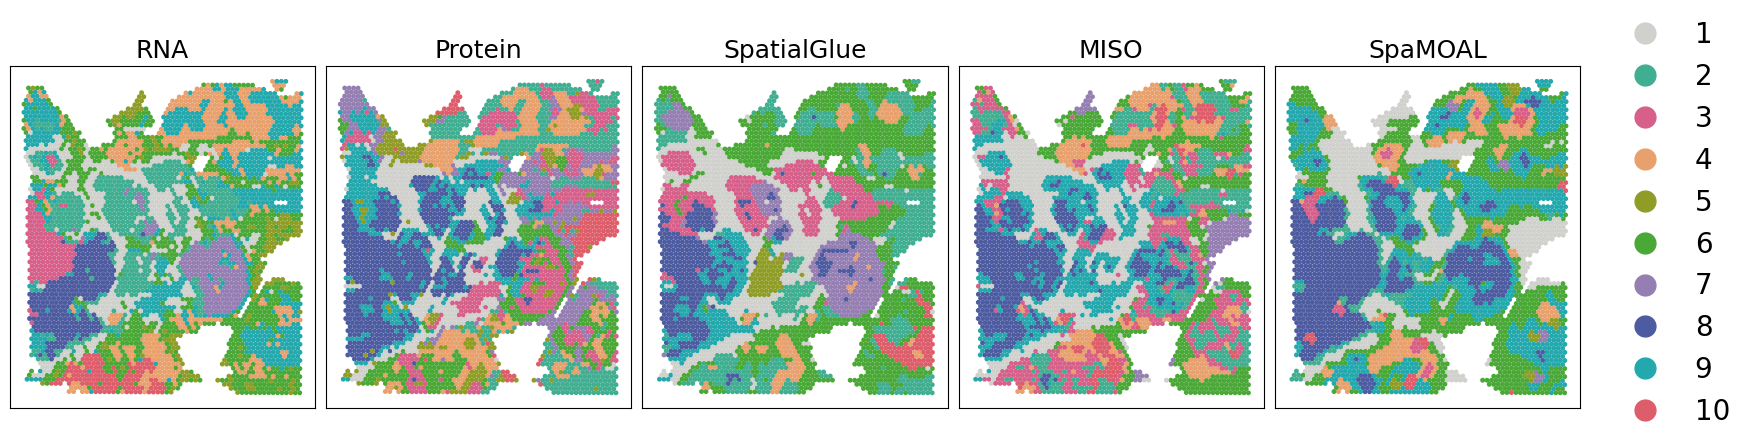

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import matplotlib.lines as mlines

adata_rotated = adata.copy()
coords = adata_rotated.obsm['spatial']
rotated_coords = np.column_stack([-coords[:, 1], coords[:, 0]])
adata_rotated.obsm['spatial'] = rotated_coords

# 2. 使用变换后的坐标绘图
fig, ax_list = plt.subplots(1, 5, figsize=(16, 4))
s_size = 50

# 绘制所有子图（使用adata_rotated）
sc.pl.embedding(adata_rotated, basis='spatial', color='RNA', title='RNA', ax=ax_list[0], s=s_size, show=False)
sc.pl.embedding(adata_rotated, basis='spatial', color='ADT', title='Protein', ax=ax_list[1], s=s_size, show=False)
sc.pl.embedding(adata_rotated, basis='spatial', color='SpatialGlue_10', title='SpatialGlue', ax=ax_list[2], s=s_size, show=False)
sc.pl.embedding(adata_rotated, basis='spatial', color='MISO_rp_10', title='MISO', ax=ax_list[3], s=s_size, show=False)
sc.pl.embedding(adata_rotated, basis='spatial', color='no_image', title='SpaMOAL', ax=ax_list[4], s=s_size, show=False)

# 设置子图属性（无需再invert_x/yaxis）
for ax in ax_list:
    ax.set_title(ax.get_title(), fontsize=18)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    legend = ax.get_legend()
    if legend is not None:
        legend.remove()
    ax.invert_xaxis()

# 定义图例颜色和标签
custom_legend = {

 '1':     '#D0D1CD',
 '2':    '#40AE91',
  '3':   '#D6608A',
  '4':   '#E8A16D',
  '5':   '#8F9D27',  
  '6':   '#49A836', 
  '7':   '#957EB2',  
  '8':   '#4D5BA0',  
  '9':   '#23A9AD', 
   '10':  '#DD5D6A'
}

# 创建图例句柄
legend_elements = [
    mlines.Line2D(
        [], [], 
        color=color, 
        marker='o', 
        linestyle='None',
        markersize=15,
        label=label
    )
    for label, color in custom_legend.items()
]

# 在右侧添加图例
fig.legend(
    handles=legend_elements,  # 使用正确的变量名
    loc='center right',
    bbox_to_anchor=(1.1, 0.5),
    frameon=False,
    title_fontsize=18,
    fontsize=20,
    ncol=1
)

plt.tight_layout(w_pad=0.8)
plt.savefig('/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/human_breast_cancerc_cluster_all.png', format='png', dpi=300, bbox_inches='tight')

plt.show()

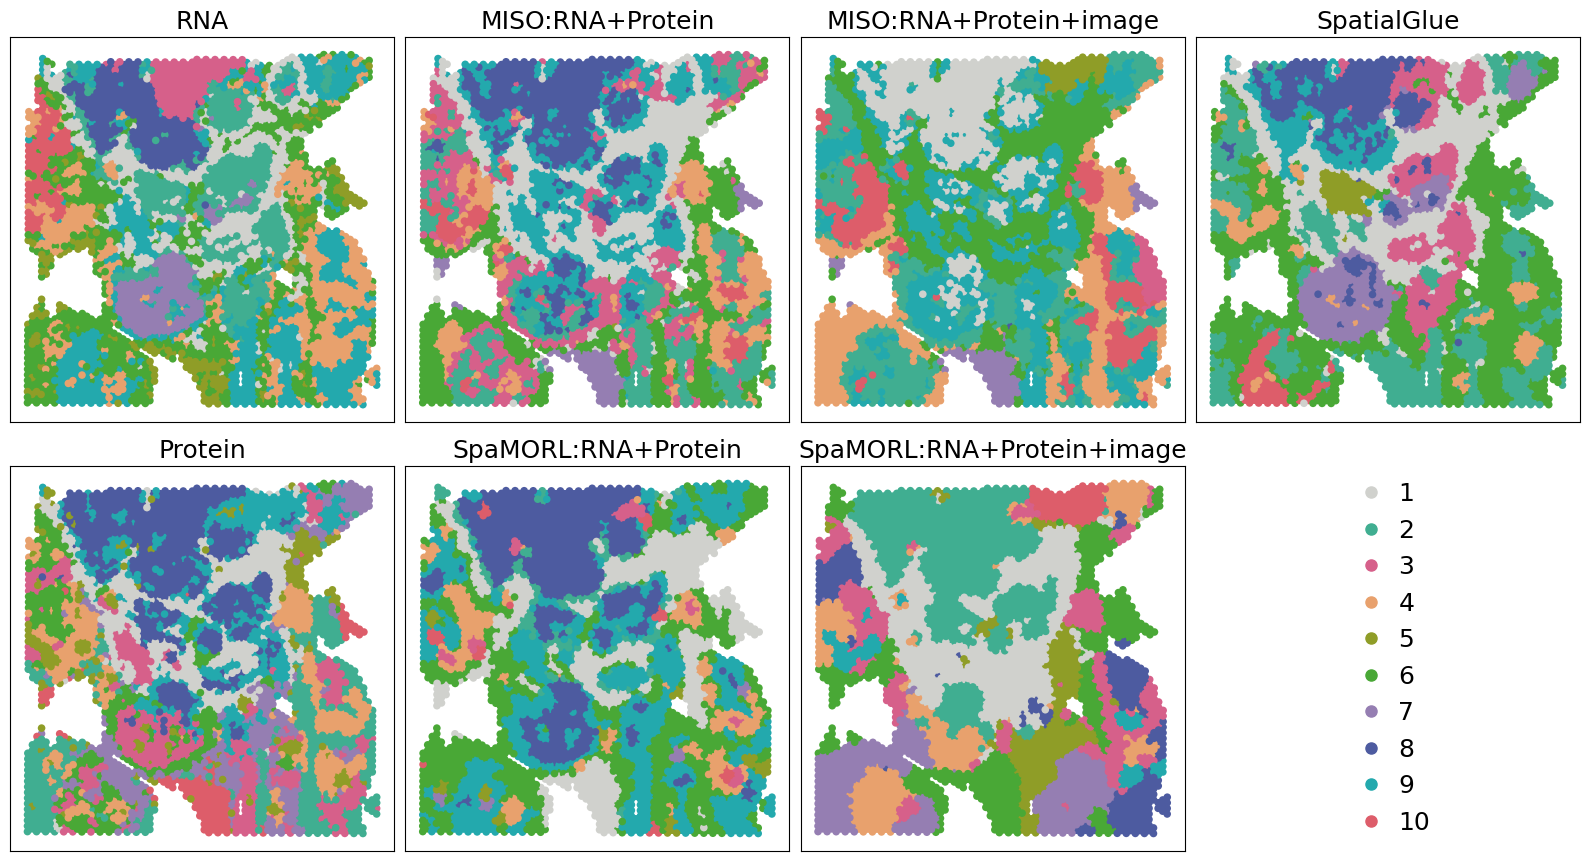

In [54]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.size'] = 10

# 创建图形和子图
fig, ax_list = plt.subplots(2, 4, figsize=(16, 9))
s_size = 120

# 绘制各个子图

sc.pl.embedding(adata, basis='spatial', color='SpatialGlue_10',title='Ground Truth', ax=ax_list[1,3],s=s_size, show=False)
sc.pl.embedding(adata, basis='spatial', color='RNA', title='RNA',ax=ax_list[0,0],s=s_size, show=False)
sc.pl.embedding(adata, basis='spatial', color='ADT', title='Protein',ax=ax_list[1,0], s=s_size,show=False)
sc.pl.embedding(adata, basis='spatial', color='MISO_rp_10', title='MISO:RNA+Protein',ax=ax_list[0,1],s=s_size, show=False)
sc.pl.embedding(adata, basis='spatial', color='MISO_10', title='MISO:RNA+Protein+image',ax=ax_list[0,2],s=s_size, show=False)
sc.pl.embedding(adata, basis='spatial', color='SpatialGlue_10',title='SpatialGlue', ax=ax_list[0,3], s=s_size,show=False)
sc.pl.embedding(adata, basis='spatial', color='no_image',title='SpaMORL:RNA+Protein', ax=ax_list[1,1], s=s_size,show=False)
sc.pl.embedding(adata, basis='spatial', color='resnet',title='SpaMORL:RNA+Protein+image', ax=ax_list[1,2], s=s_size,show=False)

ax_list[1, 3].clear()

# 设置子图属性
for row in ax_list:
    for ax in row:
        ax.set_title(ax.get_title(), fontsize=18)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        ax.invert_yaxis()
        
        # 移除现有图例
        legend = ax.get_legend()
        if legend is not None:
            legend.remove()
            
        

# 定义图例颜色和标签
custom_legend = {
     '1':     '#D0D1CD',
    '2':    '#40AE91',
    '3':   '#D6608A',
    '4':   '#E8A16D',
    '5':   '#8F9D27',  
    '6':   '#49A836', 
    '7':   '#957EB2',  
    '8':   '#4D5BA0',  
    '9':   '#23A9AD', 
    '10':  '#DD5D6A',  
}

# 创建图例句柄
legend_elements = [
    mlines.Line2D(
        [], [], 
        color=color, 
        marker='o', 
        linestyle='None',
        markersize=8,
        label=label
    )
    for label, color in custom_legend.items()
]


# 在右下角子图位置添加图例
ax_list[1, 3].legend(
    handles=legend_elements,
    loc='center',
    fontsize=18,
    frameon=False,
    ncol=1,
    handletextpad=0.1
)
ax_list[1, 3].set_frame_on(False)  # 去除子图边框

# 调整布局并保存
plt.tight_layout(w_pad=0.8)
file_fold = '/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/'
plt.savefig(file_fold + 'human_breast_cancerc_cluster_all_two_row.png', format='png', dpi=300, bbox_inches='tight')
plt.show()

In [52]:
import pandas as pd
import scanpy as sc
list_RNA=[2,5,10,4,6,1,8,7,9,3]
adata.obs['RNA']  = pd.Categorical(adata.obs['RNA'], 
                      categories=list_RNA,
                      ordered=True) 
list_ADT=[7,1,8,9,6,3,2,4,5,10]
adata.obs['ADT']  = pd.Categorical(adata.obs['ADT'], 
                      categories=list_ADT,
                      ordered=True) 
list_MISO_rp_10=[8,0,9,2,7,6,1,3,5,4]
adata.obs['MISO_rp_10']  = pd.Categorical(adata.obs['MISO_rp_10'], 
                      categories=list_MISO_rp_10,
                      ordered=True) 
list_SpatialGlue_10=[3,2,4,8,9,1,10,7,5,6]
adata.obs['SpatialGlue_10']  = pd.Categorical(adata.obs['SpatialGlue_10'], 
                      categories=list_SpatialGlue_10,
                      ordered=True) 
                     
list_no_image=[1,2,4,7,10,6,8,3,5,9]
adata.obs['no_image']  = pd.Categorical(adata.obs['no_image'], 
                      categories=list_no_image,
                      ordered=True)
                     
# list_resnet=[1,2,3,4,5,6,7,8,9,10]
# adata.obs['resnet']  = pd.Categorical(adata.obs['resnet'], 
#                       categories=list_resnet,
#                       ordered=True)  
# list_MISO_10=[0,1,2,3,4,5,6,7,8,9]
# adata.obs['MISO_10']  = pd.Categorical(adata.obs['MISO_10'], 
#                       categories=list_MISO_10,
#                       ordered=True)                                        

adata.write(adata_file)

In [11]:
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import ttest_ind
import scanpy as sc
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler
import subprocess
import time
import os
from sklearn.metrics import jaccard_score
from scipy.spatial.distance import cdist
from scipy.spatial import distance_matrix
import sys
import os
import pandas as pd
import scanpy as sc
import sys
import re
import torch
import multiprocessing
def calculate_icc(cluster_labels, data):
    unique_clusters = np.unique(cluster_labels)
    icc_values = []

    for cluster in unique_clusters:
        # 筛选出当前聚类的数据
        cluster_data = data[cluster_labels == cluster]
        # 计算当前聚类的组内方差
        within_cluster_variance = np.var(cluster_data, axis=0).mean()

        # 计算所有聚类均值
        all_cluster_means = []
        for other_cluster in unique_clusters:
            other_cluster_data = data[cluster_labels == other_cluster]
            other_cluster_mean = np.mean(other_cluster_data, axis=0)
            all_cluster_means.append(other_cluster_mean)
        all_cluster_means = np.array(all_cluster_means)
        # 计算各聚类均值之间的方差
        across_cluster_variance = np.var(all_cluster_means, axis=0).mean()

        # 计算ICC
        icc = within_cluster_variance / (within_cluster_variance + across_cluster_variance)
        icc_values.append(icc)

    return icc_values

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA  # 添加这行导入语句
#image
data = pd.read_csv('/home/lixiangyu/DMG/DMG-main/input/human_breast_cancer/human_breast_cancer_image_resnet_v2_cos_unnormalize.csv',index_col=0)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data.values)
pca = PCA(n_components=50)
pca50_image = pca.fit_transform(data_scaled)

num_gpus = 4
# RNA
adata_omics1=sc.read('/home/lixiangyu/multi-omics/SpatialGLUE/rawdata/human_breast_cancer/human_breast_cancer_rna.h5ad')
# sc.pp.filter_genes(adata_omics1, min_cells=10)
# sc.pp.normalize_total(adata_omics1, target_sum=1e4)
# sc.pp.log1p(adata_omics1)
# sc.pp.highly_variable_genes(adata_omics1, flavor="seurat_v3", n_top_genes=3000)
adata = adata_omics1[:, adata_omics1.var.highly_variable]
sc.tl.pca(adata, n_comps=50)
pca50_rna = adata.obsm['X_pca']

# Protein
import scanpy as sc

# 读取数据
adata_omics1 = sc.read('/home/lixiangyu/multi-omics/SpatialGLUE/rawdata/human_breast_cancer/human_breast_cancer_protein.h5ad')
if adata_omics1.n_vars < 50:
    pca50_atac = adata_omics1.X
else:
    sc.tl.pca(adata_omics1, n_comps=50)
    pca50_atac = adata_omics1.obsm['X_pca']
    

/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/preprocessing/_pca.py:229: ImplicitModificationWarning: Setting element `.obsm['X_pca']` of view, initializing view as actual.
  adata.obsm['X_pca'] = X_pca
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


In [13]:
print(adata)

AnnData object with n_obs × n_vars = 4169 × 3000
    obs: 'TLS_score', 'TLS_tag', 'x', 'y'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'pca'
    obsm: 'spatial', 'X_pca'
    varm: 'PCs'


In [5]:
import scanpy as sc
adata_file='/home/lixiangyu/multi-omics/SpatialGLUE/rawdata/human_breast_cancer/human_breast_cancer_7_13.h5ad'
adata=sc.read(adata_file)
print(adata)

/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/anndata/__init__.py:51: FutureWarning: `anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.
  warnings.warn(


AnnData object with n_obs × n_vars = 4169 × 15687
    obs: 'mclust', 'SpatialGlue_7', 'SpatialGlue_8', 'SpatialGlue_9', 'SpatialGlue_10', 'SpatialGlue_11', 'SpatialGlue_12', 'SpatialGlue_13', 'SpatialGlue_14', 'SpatialGlue_15', 'MISO_rp_7', 'MISO_rp_8', 'MISO_rp_9', 'MISO_rp_10', 'MISO_rp_11', 'MISO_rp_12', 'MISO_rp_13', 'no_image', 'resnet', 'RNA', 'ATAC', 'ADT', 'cluster4_vs_rest', 'MISO_7', 'MISO_8', 'MISO_9', 'MISO_10', 'MISO_11', 'MISO_12', 'MISO_13'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'ADT_cluster_colors', 'ADT_colors', 'MISO_10_colors', 'MISO_rp_10_colors', 'RNA_cluster_colors', 'RNA_colors', 'SpatialGlue_10_colors', 'SpatialGlue_colors', 'adj_spatial', 'annotation_colors', 'de_cluster4', 'hvg', 'log1p', 'no_image_colors', 'resnet_colors'
    obsm: 'SpatialGlue', 'SpatialGlue_pca', 'adj_feature', 'alpha', 'alpha_omics1', 'alpha_omics2', 'emb_latent_omics1', 'emb_latent_omics2', 'feat', 'spa

In [9]:
import pandas as pd

file_fold = "/home/lixiangyu/multi-omics/MOMG/benchmark/human_breast_cancer/output_dmg/human_breast_cancer/"
labels_none = pd.read_csv(file_fold+'human_breast_cancer_0.5_0.9_0.6_10_mclust_DMG_label.csv',index_col=0)
a = pd.DataFrame(labels_none)
labels_none = a['cluster_result']
labels_SpatialGlue=adata.obs['SpatialGlue_10']
labels_MISO=adata.obs['MISO_rp_10']

In [13]:
print('rna')
print(calculate_icc(labels_SpatialGlue, pca50_rna), end=",")
print()
print(calculate_icc(labels_MISO, pca50_rna), end=",")
print()
print('atac')
print(calculate_icc(labels_SpatialGlue, pca50_atac), end=",")
print()
print(calculate_icc(labels_MISO, pca50_atac), end=",")
print()

rna
[0.4091033, 0.6518976, 0.29601964, 0.37491345, 0.33598328, 0.36192837, 0.31562185, 0.5049361, 0.27173585, 0.36594465],
[0.44422513, 0.480842, 0.2784232, 0.27636334, 0.42368743, 0.36560488, 0.41121823, 0.0, 0.25172117, 0.3812595],
atac
[0.4199385726511344, 0.5558030236014034, 0.34081475030005365, 0.4255091935833411, 0.4453766248835209, 0.34537366390083385, 0.24946192796702812, 0.4016455674243881, 0.3091453463060993, 0.3868482713728295],
[0.04740243457020349, 0.045146163540089504, 0.03394703469573716, 0.0299505270379519, 0.042144311986191646, 0.04094671106327427, 0.03914628492672634, 0.0, 0.0382741363249696, 0.04412321129871433],


In [14]:
print('rna')
print(calculate_icc(labels_SpatialGlue, pca50_rna), end=",")
print()
print(calculate_icc(labels_MISO, pca50_rna), end=",")
print()
print(calculate_icc(labels_none, pca50_rna), end=",")
print()
print('atac')
print(calculate_icc(labels_SpatialGlue, pca50_atac), end=",")
print()
print(calculate_icc(labels_MISO, pca50_atac), end=",")
print()
print(calculate_icc(labels_none, pca50_atac), end=",")
print()

rna
[0.4091033, 0.6518976, 0.29601964, 0.37491345, 0.33598328, 0.36192837, 0.31562185, 0.5049361, 0.27173585, 0.36594465],
[0.44422513, 0.480842, 0.2784232, 0.27636334, 0.42368743, 0.36560488, 0.41121823, 0.0, 0.25172117, 0.3812595],
[0.48331797, 0.49339017, 0.47114962, 0.7068344, 0.62552583, 0.5683932, 0.54643124, 0.58772, 0.70970124, 0.5991986],
atac
[0.4199385726511344, 0.5558030236014034, 0.34081475030005365, 0.4255091935833411, 0.4453766248835209, 0.34537366390083385, 0.24946192796702812, 0.4016455674243881, 0.3091453463060993, 0.3868482713728295],
[0.04740243457020349, 0.045146163540089504, 0.03394703469573716, 0.0299505270379519, 0.042144311986191646, 0.04094671106327427, 0.03914628492672634, 0.0, 0.0382741363249696, 0.04412321129871433],
[0.4320967435399019, 0.4040438897624773, 0.4120066796389335, 0.5929359320542948, 0.513966325185135, 0.4821285531653993, 0.4596445280430788, 0.3924933558695589, 0.6254391343738609, 0.44192497946972414],


{('rna\n SpaMORL＞SpatialGlue:t=3.23(p=0.0046)\n SpaMORL＞MISO:t=3.91(p=0.0010)', 'SpatialGlue'): 0.388808409, ('rna\n SpaMORL＞SpatialGlue:t=3.23(p=0.0046)\n SpaMORL＞MISO:t=3.91(p=0.0010)', 'MISO'): 0.3313344880000001, ('rna\n SpaMORL＞SpatialGlue:t=3.23(p=0.0046)\n SpaMORL＞MISO:t=3.91(p=0.0010)', 'SpaMORL'): 0.520039136, ('atac\nSpaMORL≈SpatialGlue:t=1.683(p=0.1095)\n SpaMORL＞MISO:t=29.236(p=0.000)', 'SpatialGlue'): 0.3879916941990632, ('atac\nSpaMORL≈SpatialGlue:t=1.683(p=0.1095)\n SpaMORL＞MISO:t=29.236(p=0.000)', 'MISO'): 0.03610808154438582, ('atac\nSpaMORL≈SpatialGlue:t=1.683(p=0.1095)\n SpaMORL＞MISO:t=29.236(p=0.000)', 'SpaMORL'): 0.4378121138077494}


/tmp/ipykernel_307178/3910072415.py:106: UserWarning: Glyph 65310 (\N{FULLWIDTH GREATER-THAN SIGN}) missing from current font.
  plt.savefig('/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/ICC.png', dpi=300, bbox_inches='tight')
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 65310 (\N{FULLWIDTH GREATER-THAN SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


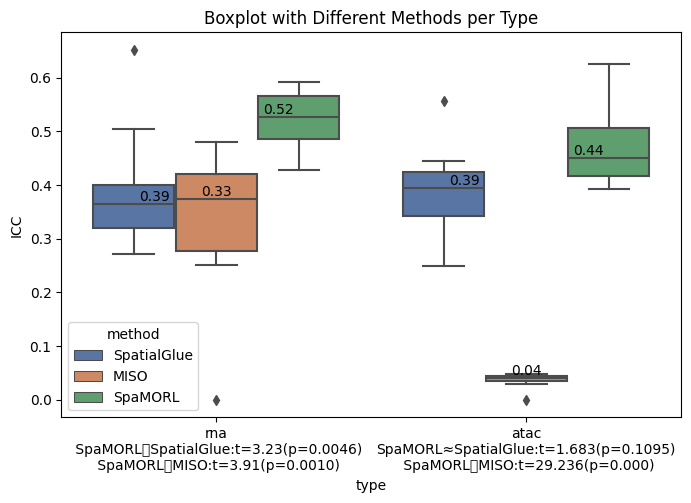

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# 整理数据，将数据转换为适合绘图的格式
data_rna = [
[0.4091033, 0.6518976, 0.29601964, 0.37491345, 0.33598328, 0.36192837, 0.31562185, 0.5049361, 0.27173585, 0.36594465],
[0.44422513, 0.480842, 0.2784232, 0.27636334, 0.42368743, 0.36560488, 0.41121823, 0.0, 0.25172117, 0.3812595],
[0.4297967, 0.42893633, 0.59257734, 0.56097144, 0.5097767, 0.49487084, 0.48182157, 0.54243684, 0.5682314, 0.5909722],
]
data_atac = [
[0.4199385726511344, 0.5558030236014034, 0.34081475030005365, 0.4255091935833411, 0.4453766248835209, 0.34537366390083385, 0.24946192796702812, 0.4016455674243881, 0.3091453463060993, 0.3868482713728295],
[0.04740243457020349, 0.045146163540089504, 0.03394703469573716, 0.0299505270379519, 0.042144311986191646, 0.04094671106327427, 0.03914628492672634, 0.0, 0.0382741363249696, 0.04412321129871433],
[0.4320967435399019, 0.4040438897624773, 0.4120066796389335, 0.5929359320542948, 0.513966325185135, 0.4821285531653993, 0.4596445280430788, 0.3924933558695589, 0.6254391343738609, 0.44192497946972414],
]

methods_rna_atac = ['SpatialGlue', 'MISO',  'SpaMORL']


# 转换为DataFrame
dfs = []
for data, data_type, methods in zip([data_rna, data_atac], 
                                     ['rna\n SpaMORL＞SpatialGlue:t=3.23(p=0.0046)\n SpaMORL＞MISO:t=3.91(p=0.0010)',
                                     'atac\nSpaMORL≈SpatialGlue:t=1.683(p=0.1095)\n SpaMORL＞MISO:t=29.236(p=0.000)'],
                                     [methods_rna_atac, methods_rna_atac]):
    for i, row in enumerate(data[:len(methods)]):
        df = pd.DataFrame({
            'type': data_type,
            'method': [methods[i]] * len(row),
            'value': row
        })
        dfs.append(df)

df = pd.concat(dfs, ignore_index=True)

# 绘制箱线图
plt.figure(figsize=(8, 5))
ax = sns.boxplot(x='type', y='value', hue='method', data=df, palette='deep')

# 按照你要求的方式计算每组均值
grouped_mean = {}
data_rna = [
[0.4091033, 0.6518976, 0.29601964, 0.37491345, 0.33598328, 0.36192837, 0.31562185, 0.5049361, 0.27173585, 0.36594465],
[0.44422513, 0.480842, 0.2784232, 0.27636334, 0.42368743, 0.36560488, 0.41121823, 0.0, 0.25172117, 0.3812595],
[0.4297967, 0.42893633, 0.59257734, 0.56097144, 0.5097767, 0.49487084, 0.48182157, 0.54243684, 0.5682314, 0.5909722],
]
data_atac = [

[0.4199385726511344, 0.5558030236014034, 0.34081475030005365, 0.4255091935833411, 0.4453766248835209, 0.34537366390083385, 0.24946192796702812, 0.4016455674243881, 0.3091453463060993, 0.3868482713728295],
[0.04740243457020349, 0.045146163540089504, 0.03394703469573716, 0.0299505270379519, 0.042144311986191646, 0.04094671106327427, 0.03914628492672634, 0.0, 0.0382741363249696, 0.04412321129871433],
[0.3993525536408737, 0.3784950713359475, 0.42869123807108334, 0.43183284014349643, 0.42556413575080415, 0.4420706011837066, 0.40338541440380904, 0.4720779073551158, 0.5111513761838953, 0.4855000000087625],
]
methods_rna = ['SpatialGlue', 'MISO', 'SpaMORL']
methods_atac = ['SpatialGlue', 'MISO',  'SpaMORL']
grouped_mean = {}
for i, row in enumerate(data_rna):
    mean_val = sum(row) / len(row)
    category = 'rna\n SpaMORL＞SpatialGlue:t=3.23(p=0.0046)\n SpaMORL＞MISO:t=3.91(p=0.0010)'
    method = methods_rna[i]
    grouped_mean[(category, method)] = mean_val

# 计算 data_atac 的均值
for i, row in enumerate(data_atac):
    mean_val = sum(row) / len(row)
    category = 'atac\nSpaMORL≈SpatialGlue:t=1.683(p=0.1095)\n SpaMORL＞MISO:t=29.236(p=0.000)'
    method = methods_atac[i]
    grouped_mean[(category, method)] = mean_val

print(grouped_mean)
# 计算每组中位数
grouped_median = df.groupby(['type','method'])['value'].median()

# 获取x轴刻度标签和对应的位置
x_tick_labels = ax.get_xticklabels()
x_tick_positions = ax.get_xticks()

# 每个x轴刻度对应的箱子数量
num_boxes_per_tick = len(df['method'].unique())
# 箱子之间的间隔比例，可根据实际情况调整
box_spacing = 0.2
# 创建method与箱体偏移量的映射字典
method_offset_mapping = {
    'SpatialGlue': 0,
    'MISO': 1,
    'SpaMORL': 2
}

# 遍历每组均值添加文本
for  i,((category, method), mean_val) in enumerate(grouped_mean.items()):
 
  
    tick_index = list(df['type'].unique()).index(category)
    box_offset = method_offset_mapping[method] % num_boxes_per_tick

    # 计算文本的x坐标
    x = x_tick_positions[tick_index] + (box_offset - (num_boxes_per_tick - 1) / 2) * box_spacing

    # 获取当前组的中位数
    median_val = grouped_median[(category, method)]
    y = median_val 

    ax.text(x, y, f'{mean_val:.2f}', ha='center', va='bottom', fontsize=10)

plt.title('Boxplot with Different Methods per Type')
plt.ylabel('ICC')
plt.savefig('/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/ICC.png', dpi=300, bbox_inches='tight')
plt.show()

In [18]:


rna_glue = data_rna[0]
rna_miso = data_rna[1]
rna_my = data_rna[2]

atac_glue = data_atac[0]
atac_miso = data_atac[1]
atac_my = data_atac[2]

t_statistic, p_value = ttest_ind(rna_my,rna_glue)
print("双样本t检验的t统计量:", t_statistic)
print("双样本t检验的p值:", p_value)
t_statistic, p_value = ttest_ind(rna_my,rna_miso)
print("双样本t检验的t统计量:", t_statistic)
print("双样本t检验的p值:", p_value)
t_statistic, p_value = ttest_ind(atac_my,atac_glue)
print("双样本t检验的t统计量:", t_statistic)
print("双样本t检验的p值:", p_value)
t_statistic, p_value = ttest_ind(atac_my,atac_miso)
print("双样本t检验的t统计量:", t_statistic)
print("双样本t检验的p值:", p_value)

双样本t检验的t统计量: 3.2312215507965427
双样本t检验的p值: 0.004633098354555692
双样本t检验的t统计量: 3.9154035750231975
双样本t检验的p值: 0.001014006707428266
双样本t检验的t统计量: 1.6835360916132573
双样本t检验的p值: 0.10953396783880291
双样本t检验的t统计量: 29.23642750744425
双样本t检验的p值: 1.2638752546458244e-16


In [36]:
import squidpy as sq

# 构建空间邻接图（Delaunay三角剖分）
sq.gr.spatial_neighbors(
    adata,
    n_neighs=6,                  # Visium建议6个邻居（六边形布局）
    coord_type="grid",           # Visium数据用"grid"，其他用"generic"
    key_added="spatial"          # 邻接矩阵存储在adata.obsp["spatial_connectivities"]
)

# 检查邻接矩阵
print(adata.obsp["spatial_connectivities"].toarray())  # 查看前5个spot的连接
import pandas as pd

# 生成聚类标签的one-hot矩阵（形状：n_spots × n_clusters）
cluster_onehot = pd.get_dummies(adata.obs["no_image"]).values
print(cluster_onehot.shape)  # 应为 (n_spots, n_clusters)


[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
(4169, 10)


In [60]:
import scanpy as sc
import squidpy as sq
file_fold = '/home/lixiangyu/multi-omics/SpatialGLUE/rawdata/human_breast_cancer/'
adata_omics1 = sc.read_h5ad(file_fold + 'human_breast_cancer_rna.h5ad')
adata_omics2 = sc.read_h5ad(file_fold + 'human_breast_cancer_protein.h5ad')
# adata_visium=sq.datasets.visium_hne_adata()
# sq.pl.spatial_scatter(adata_visium, color=["PDK1"])
# img=sq.datasets.visium_hne_image()
# sq.pl.spatial_scatter(adata_omics1, color=["SCD"])
import anndata
import matplotlib.image as mpimg
import numpy as np
# 读取图像文件
image_path = '/home/lixiangyu/DMG/DMG-main/input/human_breast_cancer/tissue_hires_image.png'  # 替换为实际的图像文件路径
img = mpimg.imread(image_path)
library_id = 'library_1'
adata_omics1.uns['spatial'] = {
    library_id: {
        'images': {
            'hires': img  # 高分辨率图像
        },
        'scalefactors': {
            "regist_target_img_scalef": 0.25943702, 
            "tissue_hires_scalef": 0.08647901, 
            "tissue_lowres_scalef": 0.025943702, 
            "fiducial_diameter_fullres": 323.7419448316662, 
            "spot_diameter_fullres": 215.82796322111085
        },
        'metadata': {
            'source_image_path': image_path  # 图像文件的路径
        }
    }
}
sq.gr.spatial_neighbors(
    adata_omics1,
    n_neighs=6,                  # 每个Spot的邻居数（根据Visium芯片布局调整）
    coord_type="grid",        # 通用坐标类型（Visium用 "grid"）
    key_added="spatial"          # 邻接矩阵的存储键（默认即 "spatial_connectivities"）
)
assert "spatial_connectivities" in adata_omics1.obsp, "邻接矩阵未生成！"
import squidpy as sq
# 计算空间自相关（高值表示基因表达在空间上聚集）
sq.gr.spatial_autocorr(
    adata_omics1,
    genes=adata.var_names.tolist(),
    mode="moran",             # 可选 "geary"（更敏感）
    n_perms=100,              # 置换检验次数
    n_jobs=4                  # 并行计算
)


# print("Top 空间可变基因:\n", significant_svgs.head(10))
# # 选择前5个空间聚集基因
# top_genes = significant_svgs.index[:50].tolist()

# # 绘制空间表达
# sq.pl.spatial_scatter(
#     adata_omics1,
#     color=top_genes,
#     size=1.2,
#     ncols=5,
#     save="/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/image/breast_spatial_hvg.png",
# )


  0%|          | 0/100 [00:00<?, ?/s]/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/lixiangyu/anaco

In [5]:
adata_omics2.uns['spatial'] = {
    library_id: {
        'images': {
            'hires': img  # 高分辨率图像
        },
        'scalefactors': {
            "regist_target_img_scalef": 0.25943702, 
            "tissue_hires_scalef": 0.08647901, 
            "tissue_lowres_scalef": 0.025943702, 
            "fiducial_diameter_fullres": 323.7419448316662, 
            "spot_diameter_fullres": 215.82796322111085
        },
        'metadata': {
            'source_image_path': image_path  # 图像文件的路径
        }
    }
}

以下基因在数据中缺失: ['LINC00926', 'NCF1', 'AC103591.3', 'HLA-DQB1', 'HLA-DQA1']


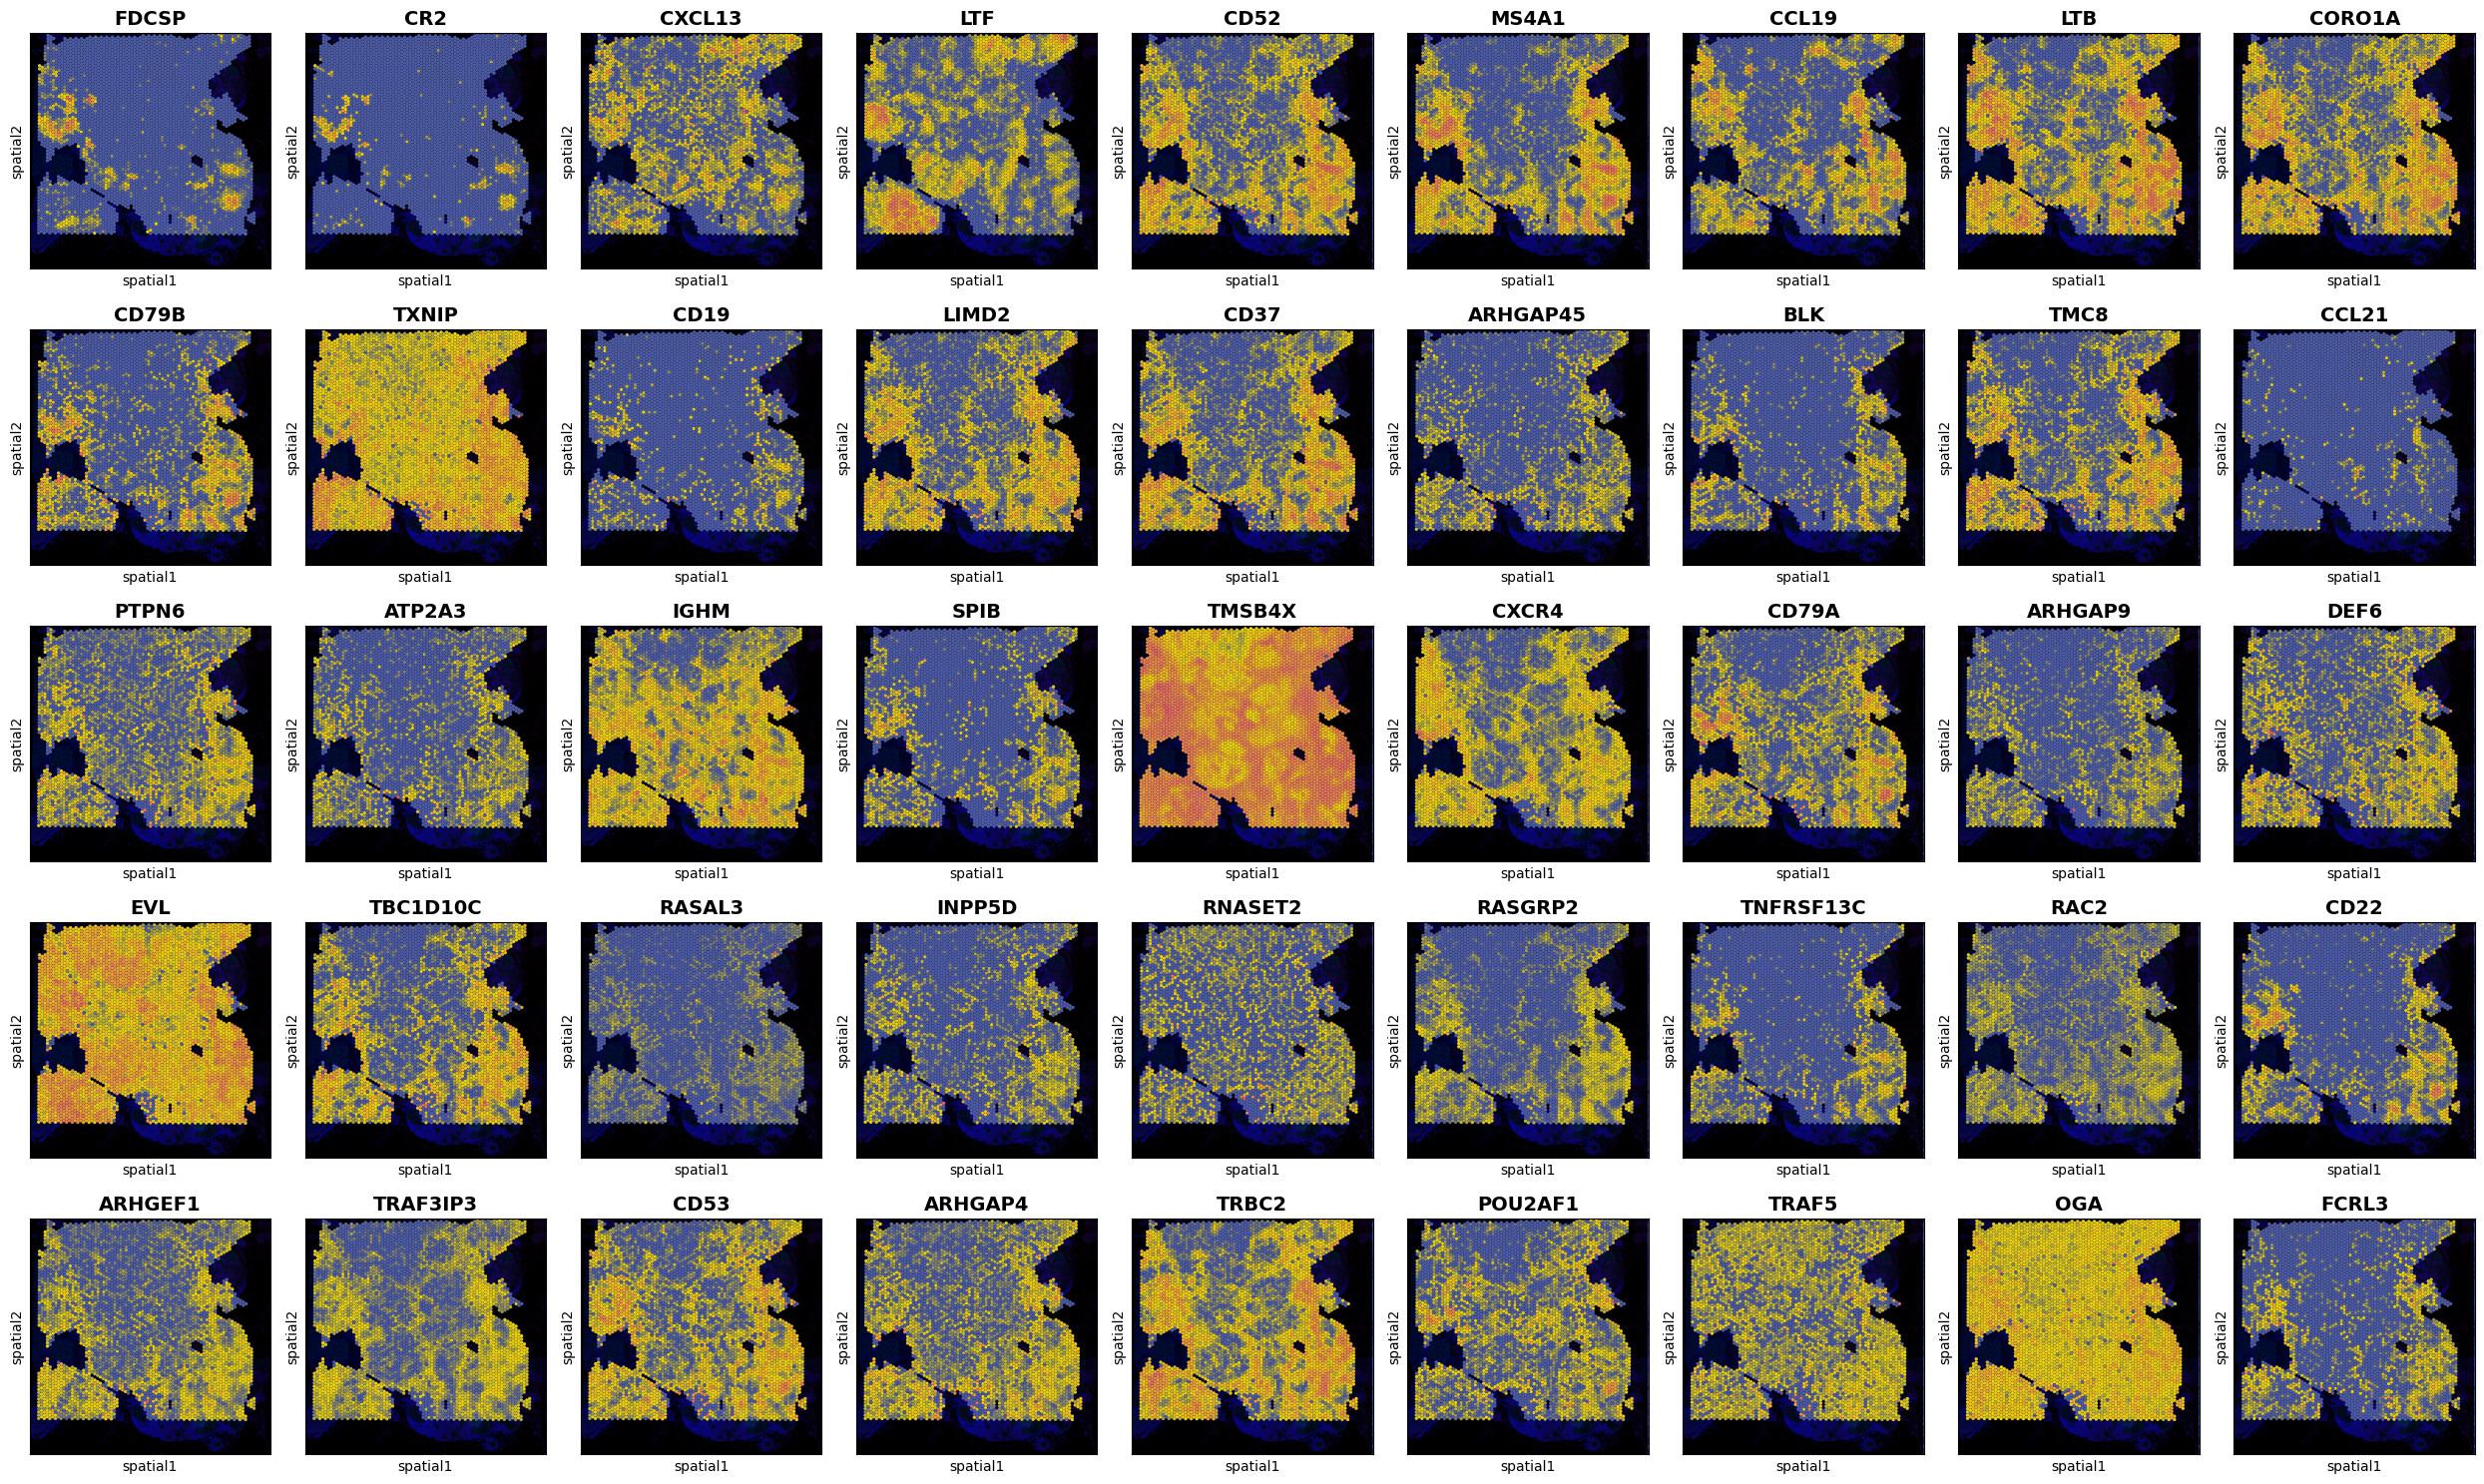

In [62]:
import matplotlib.pyplot as plt
import squidpy as sq
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

genes =["FDCSP", "CR2", "CXCL13", "LTF", "CD52", "MS4A1", "CCL19", "LTB", "CORO1A",
    "CD79B", "TXNIP", "CD19", "LIMD2", "CD37", "ARHGAP45", "BLK", "TMC8", "CCL21", "PTPN6",
    "ATP2A3", "IGHM", "SPIB", "TMSB4X", "CXCR4",  "CD79A", "ARHGAP9", "DEF6", "EVL",
    "TBC1D10C", "RASAL3", "INPP5D", "RNASET2", "RASGRP2", "TNFRSF13C", "RAC2", "CD22", "ARHGEF1", 
    "TRAF3IP3",  "CD53", "ARHGAP4", "TRBC2", "POU2AF1", "TRAF5", "OGA", "FCRL3",]

# 创建自定义颜色映射
blue_red_cmap = LinearSegmentedColormap.from_list(
    'blue_red_cmap', 
    ['#4D5BA0', "#ECD507", '#DD5D6A']
)
available_genes = adata_omics1.var_names.tolist()

# 筛选标记基因中存在于数据中的基因
valid_markers = [gene for gene in genes if gene in available_genes]

# 打印缺失的基因
missing_genes = [gene for gene in markers if gene not in available_genes]
print(f"以下基因在数据中缺失: {missing_genes}")

# 1. 显式创建 figure 和 axes
fig, axes = plt.subplots(figsize=(25, 15), ncols=9, nrows=5, squeeze=False)

# 2. 使用 squidpy 绘图，并禁用 colorbar
sq.pl.spatial_scatter(
    adata_omics1,
    color=valid_markers,
    img=True,
    size=1.5,
    ncols=4,
    cmap=blue_red_cmap,
    fig=fig,
    ax=axes.ravel(),
    colorbar=False,  # 关键修改：禁用 colorbar
)

# 3. 遍历子图并执行翻转和标题修改
for ax in axes.ravel():
    # 修改标题样式
    title = ax.get_title()
    if title:
        ax.set_title(
            title, 
            fontsize=14, 
            fontweight='bold', 
            color='black', 
        )
    
    #ax.invert_xaxis()  # 翻转 x 轴

# 4. 调整布局并保存
plt.tight_layout()
plt.savefig('/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/marker_TLS.png', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
tls_genes = [
    'CXCL13', 'CCL19', 'CCL21',     # 趋化因子
    'CD19', 'CD20', 'MS4A1', 'PAX5', # B细胞
    'CD3D', 'CD4', 'CD8A', 'ICOS',   # T细胞
    'BCL6', 'CD21', 'CD23',          # 生发中心
    'LTα', 'LTβ', 'IL21'             # 功能分子
]
def check_genes(genes):
    return [gene for gene in genes if gene in adata_omics1.var_names]

print("基因:", check_genes(tls_genes))

基因: ['CXCL13', 'CCL19', 'CCL21', 'CD19', 'MS4A1', 'PAX5', 'CD3D', 'CD4', 'CD8A', 'ICOS', 'BCL6', 'IL21']


In [29]:
# 打印邻接矩阵的稀疏性和平均连接数
print(f"邻接矩阵密度: {adata_omics1.obsp['spatial_connectivities'].nnz / (adata_omics1.n_obs**2):.4f}")
print(f"平均每个Spot的邻居数: {adata_omics1.obsp['spatial_connectivities'].sum(axis=1).mean()}")

邻接矩阵密度: 0.0014
平均每个Spot的邻居数: 5.792756056608299


In [37]:
print(adata_omics1)

AnnData object with n_obs × n_vars = 4169 × 15687
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'hvg', 'log1p', 'spatial', 'spatial_neighbors', 'moranI'
    obsm: 'spatial'
    obsp: 'spatial_connectivities', 'spatial_distances'


In [53]:
# 提取显著的空间可变基因（Moran's I > 0.2，p值 < 0.05）
svg_results = adata_omics1.uns["moranI"].sort_values("I", ascending=True)
significant_svgs = svg_results[(svg_results["I"] > 0.4) & (svg_results["pval_norm"] < 0.01)]
num_significant = len(significant_svgs)
print(f"找到了 {num_significant} 个符合条件的结果。")


找到了 475 个符合条件的结果。


In [ ]:
adata_omics2.uns["spatial"] = adata_omics1.uns["spatial"]
# 示例：可视化HER2（ERBB2）和Ki67
target_proteins = ['CD163.1', 'CR2.1', 'PCNA.1', 'VIM.1', 'KRT5.1', 'CD68.1', 'CEACAM8.1',
       'PTPRC.1', 'HLA-DRA', 'PAX5.1', 'SDC1.1', 'PTPRC.2', 'CD8A.1', 'BCL2.1',
       'mouse-IgG2a', 'mouse-IgG1k', 'mouse-IgG2bk', 'rat-IgG2a', 'CD19.1',
       'PDCD1.1', 'ACTA2.1', 'FCGR3A.1', 'ITGAX.1', 'CXCR5.1', 'EPCAM.1',
       'MS4A1.1', 'CD3E.1', 'CD14.1', 'CD40.1', 'PECAM1.1', 'CD4.1', 'ITGAM.1',
       'CD27.1', 'CCR7.1', 'CD274.1']

# 确保蛋白存在于数据中
valid_proteins = [p for p in target_proteins if p in adata_omics2.var_names]
print("可用的蛋白标记:", valid_proteins)

# 绘制空间表达
sq.pl.spatial_scatter(
    adata_omics2,
    color=valid_proteins,
    size=1.5,          # 点大小
    img=True,          # 叠加组织图像（如有）
    cmap="inferno",    # 颜色映射（适合蛋白数据）
    ncols=5,           # 每行显示3个图
    save="/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/image/protein_spatial.png"
)

In [9]:
from esda.moran import Moran
from libpysal.weights import W

# 将邻接矩阵转换为libpysal的weights对象
w = W.from_sparse(adata.obsp["spatial_connectivities"])

# 计算单个聚类（如cluster_0）的Moran's I
cluster_0 = (adata.obs["no_image"] == 1).astype(int).values
print(cluster_0)
moran = Moran(cluster_0, w, permutations=100)
print(f"Cluster 0的Moran's I: {moran.I:.3f}, p值: {moran.p_norm:.15f}")

[0 0 0 ... 0 0 1]
Cluster 0的Moran's I: 0.697, p值: 0.000000000000000


In [7]:
print(adata)

AnnData object with n_obs × n_vars = 4169 × 15687
    obs: 'mclust', 'SpatialGlue_7', 'SpatialGlue_8', 'SpatialGlue_9', 'SpatialGlue_10', 'SpatialGlue_11', 'SpatialGlue_12', 'SpatialGlue_13', 'SpatialGlue_14', 'SpatialGlue_15', 'MISO_rp_7', 'MISO_rp_8', 'MISO_rp_9', 'MISO_rp_10', 'MISO_rp_11', 'MISO_rp_12', 'MISO_rp_13', 'no_image', 'resnet', 'RNA', 'ATAC', 'ADT'
    var: 'n_cells', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'mean', 'std'
    uns: 'ADT_cluster_colors', 'ADT_colors', 'MISO_10_colors', 'MISO_rp_10_colors', 'RNA_cluster_colors', 'RNA_colors', 'SpatialGlue_10_colors', 'SpatialGlue_colors', 'adj_spatial', 'annotation_colors', 'hvg', 'log1p', 'no_image_colors', 'resnet_colors'
    obsm: 'SpatialGlue', 'SpatialGlue_pca', 'adj_feature', 'alpha', 'alpha_omics1', 'alpha_omics2', 'emb_latent_omics1', 'emb_latent_omics2', 'feat', 'spatial'


In [11]:
import scanpy as sc

# 1. 首先检查聚类标签的实际值
print("所有聚类标签:", adata.obs["no_image"].unique())

# 2. 对每个聚类找差异基因
sc.tl.rank_genes_groups(
    adata,
    groupby="no_image",
    method="wilcoxon",
    key_added="de_genes"
)

markers = sc.get.rank_genes_groups_df(adata, group=str(4), key="de_genes")
sig_markers = markers[markers["pvals_adj"] < 0.05].sort_values("logfoldchanges", ascending=False)

print(f"\nCluster {4} 的标记基因 (Top 10):")
print(sig_markers["names"].head(50).tolist())

# 3. 打印每个簇的top标记基因
# for cluster in adata.obs["no_image"].unique():
#     try:
#         markers = sc.get.rank_genes_groups_df(adata, group=str(cluster), key="de_genes")
#         sig_markers = markers[markers["pvals_adj"] < 0.05].sort_values("logfoldchanges", ascending=False)
        
#         print(f"\nCluster {cluster} 的标记基因 (Top 10):")
#         print(sig_markers["names"].head(10).tolist())
#     except KeyError:
#         print(f"\n警告: 无法获取cluster {cluster}的差异基因，可能该簇不存在或数据不足")

所有聚类标签: [7, 3, 6, 5, 1, 4, 2, 10, 9, 8]
Categories (10, int64): [1 < 2 < 4 < 7 ... 8 < 3 < 5 < 9]

Cluster 4 的标记基因 (Top 10):
['ACTB', 'LCP1', 'BIRC3', 'PFN1', 'BASP1', 'HNRNPA3', 'RFTN1', 'SRGN', 'TMSB4X', 'ANP32E', 'ARPC4', 'RAB8B', 'STK17B', 'ABRACL', 'HSPA8', 'RAP1A', 'RASSF2', 'FAM107B', 'HELLS', 'RELB', 'FNBP1', 'BMP2K', 'CSTA', 'LAPTM5', 'CXCL13', 'ARPC2', 'OAZ1', 'STK17A', 'SMAP2', 'MBD2', 'REL', 'BCL2A1', 'CLEC2D', 'MAP4K4', 'ETS1', 'SMC4', 'CD53', 'ARPC3', 'SH3KBP1', 'FUCA1', 'CTSH', 'HNRNPA2B1', 'TUBB', 'SYNE2', 'ARHGDIB', 'MCOLN2', 'CNTRL', 'CD83', 'LTB', 'CCNI']


/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_

In [38]:
# 确保已运行以下预处理步骤
sc.pp.normalize_total(adata, target_sum=1e4)  # 归一化（CPM/TPM）
sc.pp.log1p(adata)  # 对数化：log(x + 1)

In [ ]:
import scanpy as sc

# 1. 创建新的分组列（确保是分类变量）
adata.obs['cluster4_vs_rest'] = 'Rest'  # 默认所有细胞属于 'Rest'
adata.obs.loc[adata.obs['no_image'] == 4, 'cluster4_vs_rest'] = 'Cluster4'  # Cluster4 的细胞标记为 'Cluster4'

# 将分组列转换为分类变量（必须步骤！）
adata.obs['cluster4_vs_rest'] = adata.obs['cluster4_vs_rest'].astype('category')

# 检查分组列的唯一值（确保 'Cluster4' 和 'Rest' 存在）
print("分组列的唯一值:", adata.obs['cluster4_vs_rest'].unique())

# 2. 执行差异分析（Cluster4 vs. Rest）
sc.tl.rank_genes_groups(
    adata,
    groupby='cluster4_vs_rest',  # 使用新定义的分组
    groups=['Cluster4'],         # 目标组：Cluster4
    reference='Rest',            # 背景组：其他所有细胞
    method='wilcoxon',           # Wilcoxon秩和检验
    key_added='de_cluster4'      # 存储结果到新键
)

# 3. 提取差异基因（按 log2FC 和 p 值筛选）
markers_cluster4 = sc.get.rank_genes_groups_df(adata, group='Cluster4', key='de_cluster4')
print(markers_cluster4)
# 筛选显著差异基因（log2FC > 0.5 & p_adj < 0.05）
sig_markers = markers_cluster4[
    (markers_cluster4['pvals_adj'] < 0.05) & 
    (markers_cluster4['logfoldchanges'] > 0.5)
].sort_values('logfoldchanges', ascending=False)

# 提取前100个差异基因
top100_markers = sig_markers.head(200)['names'].tolist()

print(f"Cluster 4 的 Top 100 Marker Genes:\n{top100_markers}")

分组列的唯一值: ['Rest', 'Cluster4']
Categories (2, object): ['Cluster4', 'Rest']
        names     scores  logfoldchanges         pvals     pvals_adj
0        ACTB  10.644797        1.381452  1.843852e-26  2.892451e-22
1        LCP1  10.473606        2.149847  1.142075e-25  8.957862e-22
2       BIRC3   9.756420        1.923579  1.731605e-22  9.054560e-19
3        PFN1   9.726027        1.090099  2.335362e-22  9.158707e-19
4       BASP1   9.582635        2.533489  9.460003e-22  2.967981e-18
...       ...        ...             ...           ...           ...
15682  TXNDC5  -6.784373       -1.080744  1.165918e-11  1.709322e-09
15683   IGHA1  -7.388616       -3.718554  1.483647e-13  3.473727e-11
15684    IFI6  -7.742558       -1.653163  9.743665e-15  3.322802e-12
15685   IGHG1  -7.959704       -2.374166  1.724514e-15  7.638850e-13
15686    XBP1  -8.583118       -1.370817  9.233492e-18  8.046989e-15

[15687 rows x 5 columns]
Cluster 4 的 Top 100 Marker Genes:
['SERPINA9', 'HTR3A', 'FCAMR', 'GALNT

In [41]:
# 提取前100个差异基因
top100_markers = sig_markers.head(200)['names'].tolist()

print(f"Cluster 4 的 Top 100 Marker Genes:\n{top100_markers}")

Cluster 4 的 Top 100 Marker Genes:
['SERPINA9', 'HTR3A', 'FCAMR', 'GALNT14', 'CR2', 'RGS13', 'AFF2', 'KCNK12', 'FDCSP', 'TUBB2B', 'AICDA', 'ACY3', 'CDCA7', 'TREML1', 'EML6', 'PAPPA', 'SPINK2', 'DTX1', 'TMEM163', 'FAM81A', 'GCSAM', 'IL21', 'DHRS9', 'ALPK2', 'ATRNL1', 'P2RY12', 'MEF2B', 'LRMP', 'TCL1A', 'VPREB3', 'ZNF608', 'RASL11A', 'NEIL1', 'SHISA8', 'BASP1', 'ANKRD33B', 'FBXO43', 'VNN2', 'LMO2', 'NUGGC', 'CDCA2', 'RFTN1', 'PDE8B', 'BCL7A', 'CD22', 'FCRLA', 'ACHE', 'HOPX', 'MYBL1', 'IGF2BP3', 'GPR18', 'PSAT1', 'MS4A1', 'AGMAT', 'CDKN3', 'SHCBP1', 'CLU', 'GTSF1', 'P2RX5', 'SLCO5A1', 'TMEM150C', 'KBTBD8', 'RRAS2', 'ELL3', 'SPIB', 'FLT3', 'FANCA', 'PAX5', 'MATN2', 'CDC20', 'LCP1', 'BCL2A1', 'HIST1H2BH', 'TIAM2', 'TMEM131L', 'AURKB', 'FAM111B', 'BACH2', 'MME', 'CD40', 'TMEM178B', 'FCER2', 'SLC2A5', 'CD83', 'CD80', 'SH2B2', 'DLGAP5', 'CCNB2', 'PDCD1', 'PDGFD', 'LAT2', 'SLC4A8', 'BCL11A', 'ARHGAP44', 'MCOLN2', 'TEC', 'SCIMP', 'SEMA7A', 'KNL1', 'TMED8', 'BIRC3', 'RASSF2', 'ZBED2', 'SWAP70', 'C

In [32]:
gene = 'CD3D'  # 替换为你的数据中存在的基因名
expr_cluster4 = adata[adata.obs['cluster4_vs_rest'] == 'Cluster4', gene].X.mean()
expr_rest = adata[adata.obs['cluster4_vs_rest'] == 'Rest', gene].X.mean()
log2fc = np.log2(expr_cluster4 / expr_rest)
print(f"{gene}: log2FC = {log2fc}")

CD3D: log2FC = nan


/tmp/ipykernel_4073639/253494929.py:4: RuntimeWarning: invalid value encountered in log2
  log2fc = np.log2(expr_cluster4 / expr_rest)


In [31]:
# 检查 Cluster4 和 Rest 组的表达矩阵
print("Cluster4 组的平均表达量:", adata[adata.obs['cluster4_vs_rest'] == 'Cluster4', :].X.mean(axis=0))
print("Rest 组的平均表达量:", adata[adata.obs['cluster4_vs_rest'] == 'Rest', :].X.mean(axis=0))

Cluster4 组的平均表达量: [-0.08913226 -0.29629233 -0.05315012 ... -0.08623851 -0.15329506
  0.0804995 ]
Rest 组的平均表达量: [ 0.00119184  0.00396124  0.00071037 ...  0.00115293  0.00204939
 -0.00107619]


In [40]:
print(adata[adata.obs['cluster4_vs_rest'] == 'Cluster4', :].X)

[[0.         0.         0.         ... 1.5252054  2.3369699  2.980601  ]
 [0.         0.         0.         ... 1.5165557  1.8460512  2.8844316 ]
 [0.         0.         0.         ... 0.52815306 2.4368503  2.8334098 ]
 ...
 [0.         0.         0.         ... 1.1972713  2.399225   3.3844986 ]
 [0.         0.         0.         ... 1.4792906  2.0515127  3.2870097 ]
 [0.         0.         0.         ... 0.9676547  2.4278522  2.4278522 ]]


In [37]:
print(adata.X)

[[ 0  0  0 ...  1  1  3]
 [ 0  0  0 ...  6 23 42]
 [ 0  0  0 ...  3 13 20]
 ...
 [ 0  0  0 ...  1  5  1]
 [ 0  0  0 ...  2 10 30]
 [ 0  0  0 ...  0  4  0]]


In [ ]:
import squidpy as sq
# 示例：可视化HER2 (ERBB2) 和上皮标记 (EPCAM)
library_id = list(adata_omics1.uns["spatial"].keys())[0]
sq.pl.spatial_scatter(
    adata_omics1,
    library_key=library_id,
    color=["ERBB2", "EPCAM"],  # 可替换为其他标记物
    size=2,                 # 点大小
    img=False,                 # 显示组织图像
    figsize=(10, 4),          # 图像大小
    ncols=2,                  # 每行显示2个图
    vmin=0,                   # 表达量最小值
    vmax="99",             # 最大值设为99.9%分位数（避免异常值影响）
    cmap="magma",             # 颜色映射
    save="/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/image/breast_markers.png" 
)

In [139]:
print(adata.obsm['SpatialGlue'].shape)

(4169, 64)


In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np

print(adata.obsm['SpatialGlue'].shape)
expression_matrix = adata.obsm['SpatialGlue']
obs_index = adata.obs.index
var_index = pd.Index(range(expression_matrix.shape[1]), name='var_names')
obs_data = pd.DataFrame(index=obs_index)）
var_data = pd.DataFrame(index=var_index)
adata_SpatialGlue = sc.AnnData(
    X=expression_matrix,
    obs=obs_data,
    var=var_data
)
adata_SpatialGlue.obsm['spatial']=adata.obsm['spatial']
print(adata_SpatialGlue)
sq.gr.spatial_neighbors(
    adata_SpatialGlue,
    n_neighs=6,                  # 每个Spot的邻居数（根据Visium芯片布局调整）
    coord_type="grid",        # 通用坐标类型（Visium用 "grid"）
    key_added="spatial"          # 邻接矩阵的存储键（默认即 "spatial_connectivities"）
)
assert "spatial_connectivities" in adata_SpatialGlue.obsp, "邻接矩阵未生成！"
import squidpy as sq
# 计算空间自相关（高值表示基因表达在空间上聚集）
sq.gr.spatial_autocorr(
    adata_SpatialGlue,
    mode="moran",             # 可选 "geary"（更敏感）
    n_perms=100,              # 置换检验次数
    n_jobs=4                  # 并行计算
)
adata_SpatialGlue.write('/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/SpatialGlue_Moran.h5ad')
# 提取显著的空间可变基因（Moran's I > 0.2，p值 < 0.05）
svg_results = adata_SpatialGlue.uns["moranI"].sort_values("I", ascending=True)
significant_svgs = svg_results[(svg_results["I"] > 0.4) & (svg_results["pval_norm"] < 0.01)]
num_significant = len(significant_svgs)
print(f"找到了 {num_significant} 个符合条件的结果。")
moran_scores_SpatialGlue = adata_SpatialGlue.uns['moranI']['I'].values


(4169, 64)
AnnData object with n_obs × n_vars = 4169 × 64
    obsm: 'spatial'


In [ ]:
import scanpy as sc
import pandas as pd
import numpy as np
emb=np.load('/home/lixiangyu/multi-omics/MISO/miso/tutorial/miso_tutorial_data/human_breast_cancer/emb_rna_protein.npy')
print(emb.shape)
expression_matrix = emb
obs_index = adata.obs.index
var_index = pd.Index(range(expression_matrix.shape[1]), name='var_names')
obs_data = pd.DataFrame(index=obs_index)
var_data = pd.DataFrame(index=var_index)
adata_MISO = sc.AnnData(
    X=expression_matrix,
    obs=obs_data,
    var=var_data
)
adata_MISO.obsm['spatial']=adata.obsm['spatial']
print(adata_MISO)
sq.gr.spatial_neighbors(
    adata_MISO,
    n_neighs=6,                  # 每个Spot的邻居数（根据Visium芯片布局调整）
    coord_type="grid",        # 通用坐标类型（Visium用 "grid"）
    key_added="spatial"          # 邻接矩阵的存储键（默认即 "spatial_connectivities"）
)
assert "spatial_connectivities" in adata_MISO.obsp, "邻接矩阵未生成！"
import squidpy as sq
# 计算空间自相关（高值表示基因表达在空间上聚集）
sq.gr.spatial_autocorr(
    adata_MISO,
    mode="moran",             # 可选 "geary"（更敏感）
    n_perms=100,              # 置换检验次数
    n_jobs=4                  # 并行计算
)
adata_MISO.write('/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/MISO_Moran.h5ad')
# 提取显著的空间可变基因（Moran's I > 0.2，p值 < 0.05）
svg_results = adata_MISO.uns["moranI"].sort_values("I", ascending=True)
significant_svgs = svg_results[(svg_results["I"] > 0.4) & (svg_results["pval_norm"] < 0.01)]
num_significant = len(significant_svgs)
print(f"找到了 {num_significant} 个符合条件的结果。")
moran_scores_MISO = adata_MISO.uns['moranI']['I'].values

(4169, 96)
AnnData object with n_obs × n_vars = 4169 × 96
    obsm: 'spatial'


  0%|          | 0/100 [00:00<?, ?/s]/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
  1%|          | 1/100 [00:10<18:00, 10.91s/]/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
 

In [166]:
moran_scores_MISO = adata_MISO.uns['moranI']['I'].values
moran_scores_SpatialGlue = adata_SpatialGlue.uns['moranI']['I'].values
moran_scores_SpaMORL = adata_SpaMORL.uns['moranI']['I'].values

In [4]:
import scanpy as sc
import pandas as pd
import numpy as np
embedding=pd.read_csv("/home/lixiangyu/DMG/DMG-main/benchmark/human_breast_cancer/output_dmg/none_0.5_none/none_human_breast_cancer_0.7_1.0_0.5_10_mclust_DMG_embedding.csv",index_col=0)
print(embedding)

             0         1         2         3         4         5         6  \
0    -0.398391 -0.264506  0.158127  0.740253 -0.266569  0.178915  0.730838   
1     0.305554  0.497289 -0.151249  0.093276  0.553670 -0.214600 -0.326756   
2     0.915651  0.020886  0.421129 -0.265924  0.227011  0.012173  0.503471   
3     0.118936  0.120219  0.109980 -0.236248  0.237676 -0.223544 -0.264474   
4     0.216845  0.384445 -0.147013  0.162669  0.414439 -0.168500 -0.123617   
...        ...       ...       ...       ...       ...       ...       ...   
4164  3.302316 -4.526871  4.444146  2.564314  2.379824  2.358303  0.143012   
4165  0.787518  0.053223  0.329471 -0.214343  0.242721  0.317293 -0.337048   
4166  0.424015 -0.204774  0.093435 -0.107956 -0.040664  0.235133  0.293546   
4167 -0.005436  0.486146 -0.204663 -0.147464  0.476301 -0.371234 -0.531199   
4168  0.510639  0.225088 -0.333747  1.195794  0.156884  0.430076  1.191366   

             7         8         9        10        11  
0    -

In [ ]:
print(adata.obs['no_image'])

In [175]:
import scanpy as sc
import pandas as pd
import numpy as np
embedding=pd.read_csv("/home/lixiangyu/DMG/DMG-main/benchmark/human_breast_cancer/output_dmg/none_0.5_none/none_human_breast_cancer_0.7_1.0_0.5_10_mclust_DMG_embedding.csv",index_col=0)
print(embedding.shape)
expression_matrix = embedding.values
obs_index = adata.obs.index
var_index = pd.Index(range(expression_matrix.shape[1]), name='var_names')
obs_data = pd.DataFrame(index=obs_index)
var_data = pd.DataFrame(index=var_index)
adata_SpaMORL = sc.AnnData(
    X=expression_matrix,
    obs=obs_data,
    var=var_data
)
adata_SpaMORL.obsm['spatial']=adata.obsm['spatial']
print(adata_SpaMORL)
sq.gr.spatial_neighbors(
    adata_SpaMORL,
    n_neighs=6,                  # 每个Spot的邻居数（根据Visium芯片布局调整）
    coord_type="grid",        # 通用坐标类型（Visium用 "grid"）
    key_added="spatial"          # 邻接矩阵的存储键（默认即 "spatial_connectivities"）
)
assert "spatial_connectivities" in adata_SpaMORL.obsp, "邻接矩阵未生成！"
import squidpy as sq
# 计算空间自相关（高值表示基因表达在空间上聚集）
sq.gr.spatial_autocorr(
    adata_SpaMORL,
    mode="moran",             # 可选 "geary"（更敏感）
    n_perms=100,              # 置换检验次数
    n_jobs=4                  # 并行计算
)
adata_SpaMORL.write('/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/SpaMORL_Moran.h5ad')
# 提取显著的空间可变基因（Moran's I > 0.2，p值 < 0.05）
svg_results = adata_SpaMORL.uns["moranI"].sort_values("I", ascending=True)
significant_svgs = svg_results[(svg_results["I"] > 0.4) & (svg_results["pval_norm"] < 0.01)]
num_significant = len(significant_svgs)
print(f"找到了 {num_significant} 个符合条件的结果。")
moran_scores_SpaMORL = adata_SpaMORL.uns['moranI']['I'].values

(4169, 12)
AnnData object with n_obs × n_vars = 4169 × 12
    obsm: 'spatial'


  0%|          | 0/100 [00:00<?, ?/s]/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
  1%|          | 1/100 [00:10<17:40, 10.71s/]/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION = 12050. The TBB threading layer is disabled.
  warnings.warn(problem)
 48%|████▊     | 48/100 [00:10<00:08,  6.28/s]/home/lixiangyu/anaconda3/envs/dmg/lib/python3.9/site-packages/numba/np/ufunc/parallel.py:371: NumbaWarning: The TBB threading layer requires TBB version 2021 update 6 or later i.e., TBB_INTERFACE_VERSION >= 12060. Found TBB_INTERFACE_VERSION =

找到了 12 个符合条件的结果。


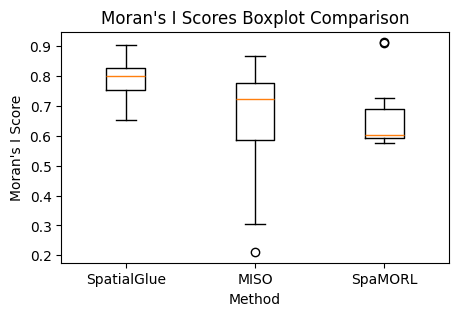

In [176]:
import matplotlib.pyplot as plt
import numpy as np


# 将数据整理成一个列表，每个元素是一个数据集
data = [moran_scores_SpatialGlue, moran_scores_MISO, moran_scores_SpaMORL]

# 定义每个箱子的标签
labels = [ 'SpatialGlue', 'MISO', 'SpaMORL']

# 创建箱线图
plt.figure(figsize=(5, 3))
plt.boxplot(data, labels=labels)

# 添加标题和轴标签
plt.title('Moran\'s I Scores Boxplot Comparison')
plt.xlabel('Method')
plt.ylabel('Moran\'s I Score')
plt.savefig('/home/lixiangyu/multi-omics/MOMG/input/human_breast_cancer/moran.png')
# 显示图形
plt.show()

In [165]:
print(moran_scores_SpaMORL)
print(moran_scores_SpatialGlue)
print(moran_scores_MISO)

[Ellipsis]
[Ellipsis]
[Ellipsis]
